In [1]:
from ipynb.fs.full.arl_libq import *

# ESTU Experiment

Entanglement Sources Through Unitary

### Experimental Setup

Example with 3 entanglement sources:
```
                            ┌─────────────┐
[Detector] ◄──[ent1 (H)]──► │             │──► [Detector]
[Detector] ◄──[     (V)]──► │             │──► [Detector]
[Detector] ◄──[ent2 (H)]──► │ Haar-Random │──► [Detector]
[Detector] ◄──[     (V)]──► │   Unitary   │──► [Detector]
[Detector] ◄──[ent3 (H)]──► │             │──► [Detector]
[Detector] ◄──[     (V)]──► │             │──► [Detector]
                            └─────────────┘
```

### The Math Behind the QM Simulation

Let $k$ be the number of entanglement sources. 
Then, the initial state is 
$$2^{-k/2}(|HH\rangle+|VV\rangle)^{\otimes k} = 2^{-k/2}(|1010\rangle+|0101\rangle)^{\otimes k},$$
but reordered so the left (first two) modes of each ent come first, followed by all the right (second two) modes. 
Mathematically, this is 
$$\frac{1}{\sqrt{2^{k}}} \sum_{x \in S} | xx \rangle$$
Where 
$S 
:= \left\{ x \in \{0,1\}^{2k} : \forall i \in \{1, \dots, k\},\ x_{2i-1} \ne x_{2i} \right\} 
= \{01,10\}^{k}$.

We then apply a $2k \times 2k$ Haar-random unitary $U_\text{haar}$ to the right modes by applying the $4k \times 4k$ unitary $U = I \oplus U_\text{haar}$.

Note that there are $2k$ photons in the system, with $k$ of those passing through $U_\text{haar}$, and no mode has more than one photon in it initially.


### Performing the ESTU Experiment

In [2]:
def get_lossless_estu_heralds(num_src):
    n = num_src
    m = 2*num_src
    
    all_possible_heralds = []
    for i in range(2**n):
        state = [0]*m
        for digit in range(n):
            # each entanglement source either releases H light
            # in both directions or V light in both directions
            ent_index = 2*digit
            h_or_v = (i % 2)
            state[ent_index + h_or_v] = 1
            i >>= 1
        all_possible_heralds.append(tuple(state))
        
    return all_possible_heralds

In [3]:
def qm_estu(U, heralds):
    '''Simulates Quantum Mechanical predictions of detection event likelyhoods
    resulting from passing heralded states through the provided unitary.
    Returns map (heralded_state -> (detection_event -> probability)).
    
    U : m x m matrix
        = unitary to be applied.
    heralds : List(tuple(int)) 
        = list of heralded states.'''

    qm_distrs = defaultdict(lambda: defaultdict(lambda: 0))
    
    hsu = {}

    for initial_state in heralds:
        
        n = sum(initial_state)
        if n not in hsu:
            hsu[n] = HilbertSpaceUnitary(U, n)
        final_state = hsu[n].apply(initial_state)
        
        for fock_outcome in final_state:
            amp = final_state[fock_outcome]
            probability = np.real(amp * conj(amp)) # casting will never affect value
            det_event = tuple([(1 if photon_num > 0 else 0) for photon_num in fock_outcome])
            qm_distrs[initial_state][det_event] += probability
    
    return qm_distrs

In [4]:
def stoch_estu(
    U, 
    heralds, 
    r=1, 
    herald_gamma=DEFAULT_MEAS_THRESH, 
    out_gamma=DEFAULT_MEAS_THRESH, 
    N=1000
):
    '''Simulates Stochastic Mechanical predictions of detection event likelyhoods
    resulting from heralding provided states and applying provided unitary.
    Returns map (heralded_state -> (detection_event -> probability)).
    
    U : m x m matrix
        = unitary to be applied.
    heralds : List(tuple(int)) 
        = list of heralded states.
    r : float
        = squeezing strength.
    herald_gamma : float
        = measurement threshold for heralding detectors.
    out_gamma : float
        = measurement threshold for output detectors.
    N : int
        = number of samples.'''
    
    # TODO: change asserts to proper error handling
    m = len(heralds[0])
    assert(m % 2 == 0)
    assert(all([len(herald) == m for herald in heralds]))
    num_src = m // 2
    
    ents = [ent(N, r=r) for i in range(num_src)]
    l_ents = np.concatenate(tuple([ent[0] for ent in ents]))
    r_ents = np.concatenate(tuple([ent[1] for ent in ents]))
    r_ents = U @ r_ents
    dl = threshold_detector(l_ents, herald_gamma)
    dr = threshold_detector(r_ents, out_gamma)
    
    stoch_distrs = defaultdict(lambda: defaultdict(lambda: 0))
    
    for herald in heralds:
        herald_mask = trials_with_outcome(herald, dl)
        counts = Counter(map(tuple, dr.astype(int).T[herald_mask]))
        stoch_normalization = 0
        for det_event in counts.keys():
            stoch_distrs[herald][det_event] = counts[det_event]
            stoch_normalization += counts[det_event]
        if stoch_normalization != 0:
            for det_event in stoch_distrs[herald]:
                stoch_distrs[herald][det_event] /= stoch_normalization
                
    return stoch_distrs

In [5]:
def estu(
    num_src,
    U=None, 
    heralds=None, 
    r=1, 
    herald_gamma=DEFAULT_MEAS_THRESH, 
    out_gamma=DEFAULT_MEAS_THRESH, 
    N=1000000
):
    '''Entanglement Sources Through Unitary (ESTU) experiment.
    Defaults to applying Haar-Random Unitary to all possible 
    lossless heralds. No postselection. Converts Fock states
    to 0/1 detection events.'''
    
    n = num_src     # each ent sends one photon to the right
    m = 2*num_src   # two modes exit the right side of each ent (rH,rV)
    
    if U is None:
        U = qr_haar(m)
    if not is_unitary(U):
        raise ValueError('U must be unitary.')
    if U.shape != (m, m):
        raise ValueError(f'Unitary must act on {m} modes.')
    
    if heralds is None:
        heralds = get_lossless_estu_heralds(num_src)
    
    qm_distrs = qm_estu(U, heralds)
    stoch_distrs = stoch_estu(U, heralds, r, herald_gamma, out_gamma, N)

    return qm_distrs, stoch_distrs

### Optimization

In [6]:
def avg_distr_distance(qm_distrs, stoch_distrs, dist_func=DEFAULT_DIST_FUNC):
    heralds = set()
    heralds.update(qm_distrs.keys(), stoch_distrs.keys())
    
    dist_sum = 0
    for herald in heralds:
        exp_pr_distr, obs_pr_distr = distr_dicts_to_arrays(qm_distrs[herald], stoch_distrs[herald])
        dist_sum += dist_func(exp_pr_distr, obs_pr_distr)
        
    return dist_sum / len(heralds)

In [7]:
def optimizable_estu(x, num_src=3, U=None, heralds=None, N=100000, shots=10, dist_func=DEFAULT_DIST_FUNC):
    running_tot = 0
    for i in range(shots):
        qm_distrs, stoch_distrs = estu(
            num_src, 
            U=U,
            heralds=heralds,
            r=x[0], 
            herald_gamma=x[1], 
            out_gamma=x[2], 
            N=N
        )
        running_tot += avg_distr_distance(qm_distrs, stoch_distrs, dist_func)
    return running_tot / shots

### Displaying results

In [8]:
DIST_FUNCS = [
    ('Trace Distance', trace_dist), 
    ('Hellinger Distance', hellinger_dist), 
    ('Chi-Square Test Statistic', zeroless_chi_square_test_statistic), 
    ('Chi-Square p-value', lambda e,o : zeroless_chi_square(e,o)[1])
]

def analyze_estu(
    num_src,
    U=None, 
    heralds=None, 
    r=1, 
    herald_gamma=DEFAULT_MEAS_THRESH, 
    out_gamma=DEFAULT_MEAS_THRESH, 
    N=1000000
):
    qm_distrs, stoch_distrs = estu(num_src, U, heralds, r, herald_gamma, out_gamma, N)
        
    heralds = set()
    heralds.update(qm_distrs.keys(), stoch_distrs.keys()) # Should be the same, but doesn't hurt
    for herald in heralds:
        analyze_distr(qm_distrs[herald], stoch_distrs[herald], title=f'Comparing QM and Spoof, Heralding {herald}')
        
    if len(heralds) > 1:
        print("---")
        print("General statistics:")
        for dist_name, dist_func in DIST_FUNCS:
            avg = avg_distr_distance(qm_distrs, stoch_distrs, dist_func=dist_func)
            print(f"Average {dist_name}: {avg}")

## ESTU Tests

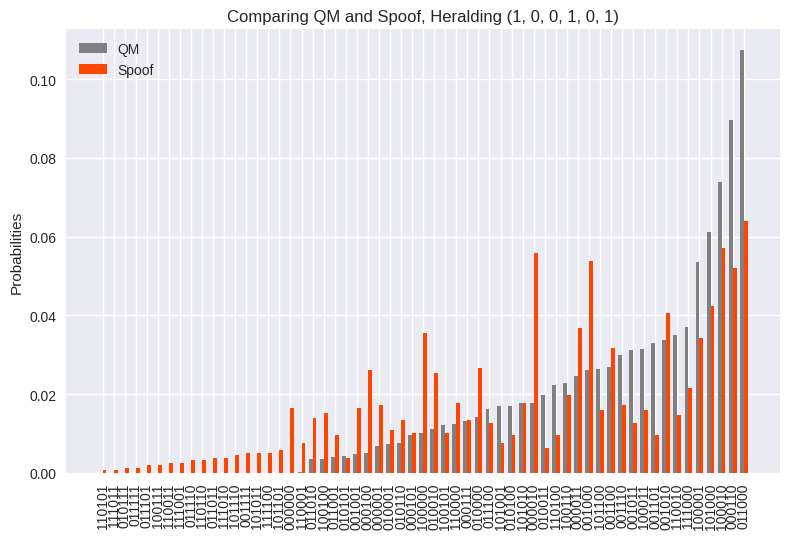

Trace Distance: 0.30448271170681673
Hellinger Distance: 0.29833038142638396
Chi-Square Test Statistic: 1.5077813904205262
Chi-Square p-value: 1.0



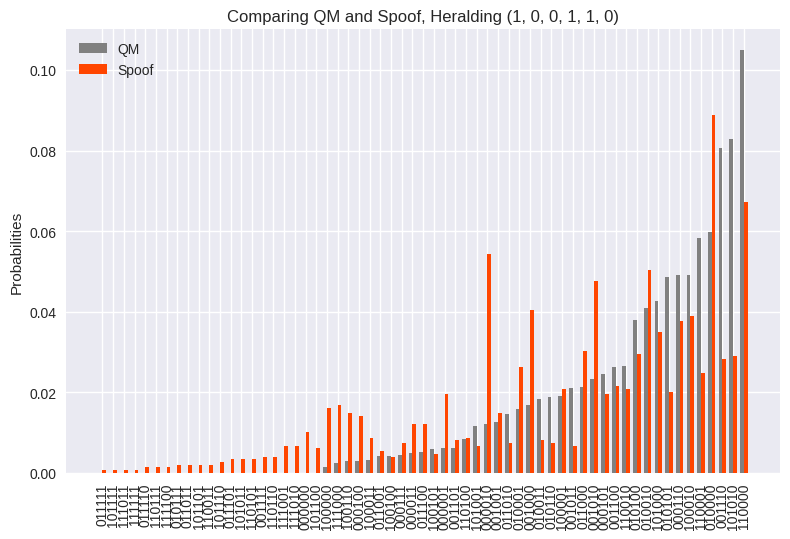

Trace Distance: 0.30891922942932165
Hellinger Distance: 0.30416401471026855
Chi-Square Test Statistic: 3.1729162181601094
Chi-Square p-value: 0.9999999999999991



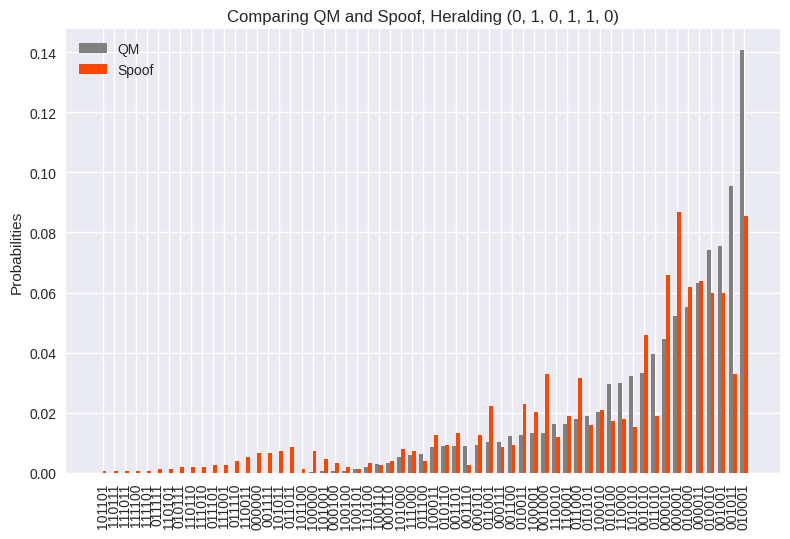

Trace Distance: 0.23193205603381856
Hellinger Distance: 0.2475370630411924
Chi-Square Test Statistic: 0.49829369462970713
Chi-Square p-value: 1.0



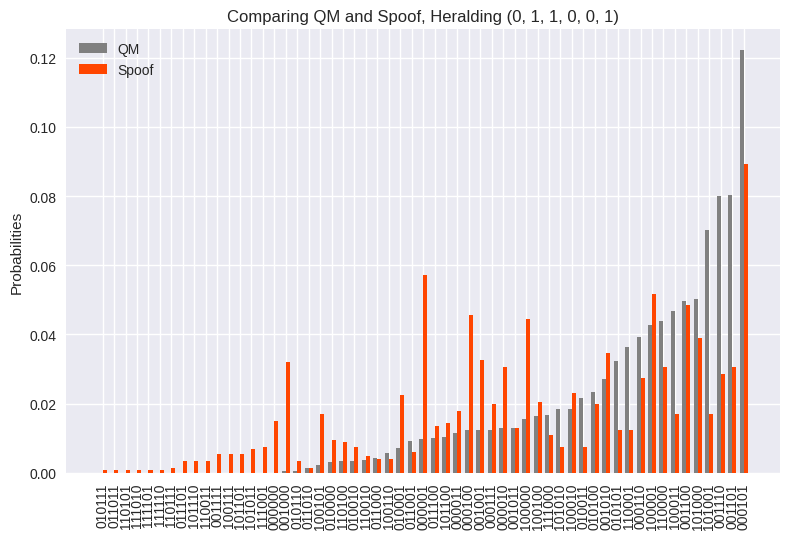

Trace Distance: 0.3374107453990601
Hellinger Distance: 0.33680913010417257
Chi-Square Test Statistic: 3.9260499147293224
Chi-Square p-value: 0.999999999999954



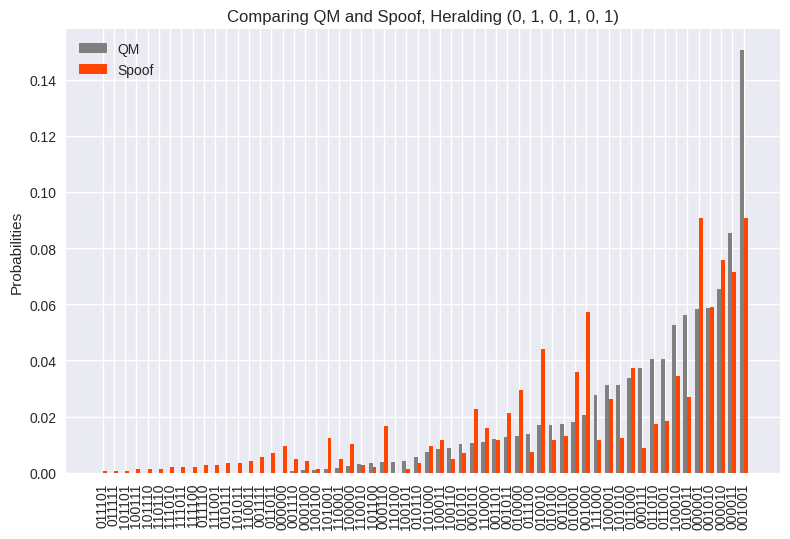

Trace Distance: 0.26886933171400185
Hellinger Distance: 0.2716216346824999
Chi-Square Test Statistic: 0.5803683137525842
Chi-Square p-value: 1.0



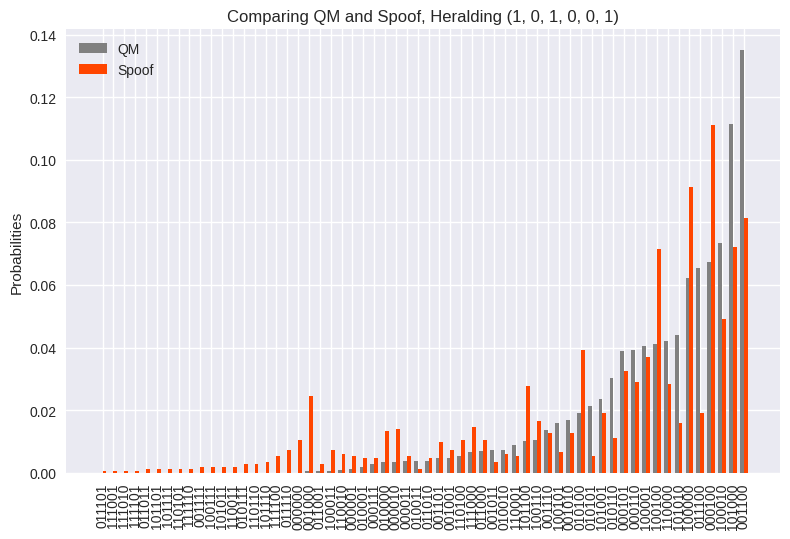

Trace Distance: 0.29014930143221984
Hellinger Distance: 0.28225744742799597
Chi-Square Test Statistic: 1.8555043742712092
Chi-Square p-value: 1.0



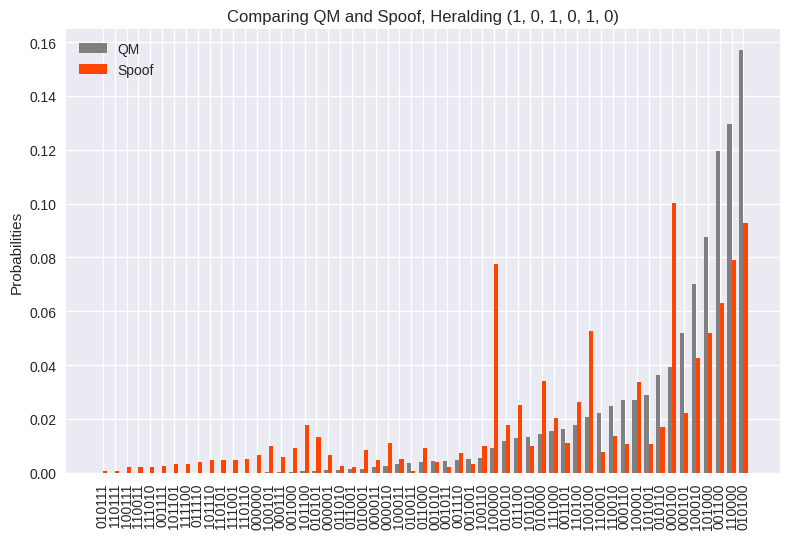

Trace Distance: 0.35893291542522404
Hellinger Distance: 0.3272945065347532
Chi-Square Test Statistic: 2.654693056878667
Chi-Square p-value: 1.0



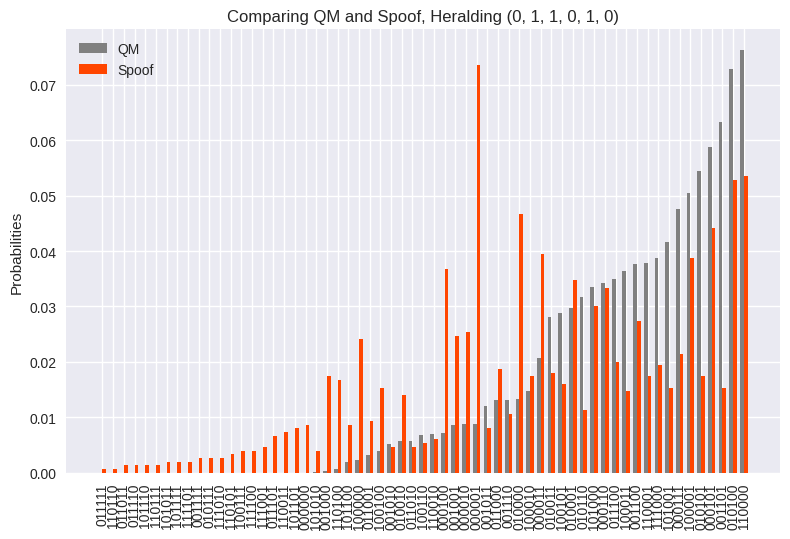

Trace Distance: 0.3513943830720849
Hellinger Distance: 0.35233618816531376
Chi-Square Test Statistic: 3.393909411369145
Chi-Square p-value: 0.9999999999999968

---
General statistics:
Average Trace Distance: 0.3065113342765684
Average Hellinger Distance: 0.30254379576157253
Average Chi-Square Test Statistic: 2.198689546776409
Average Chi-Square p-value: 0.9999999999999937


In [9]:
analyze_estu(3)

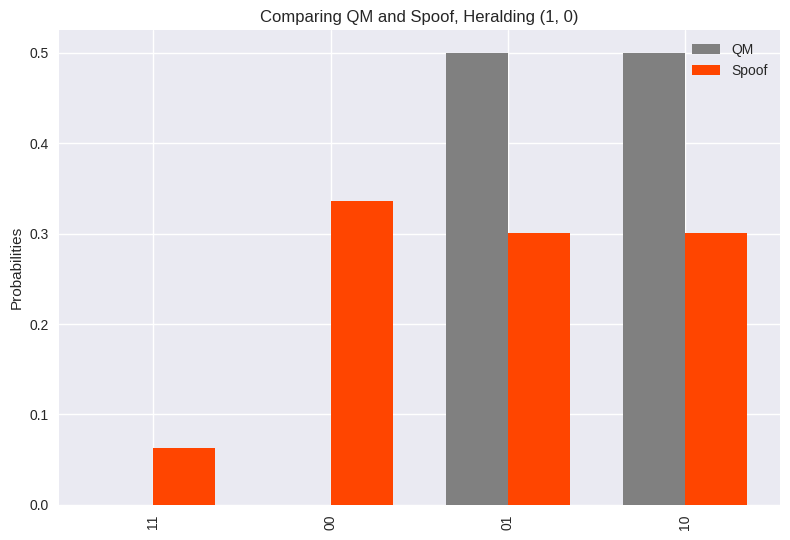

Trace Distance: 0.39894773458561605
Hellinger Distance: 0.4740510458612636
Chi-Square Test Statistic: 1.8840736890777145e-09
Chi-Square p-value: 0.9999653670884517



In [10]:
# Basic Hadamard
analyze_estu(1, U=hadamard, heralds=[(1,0)], N=1000000)

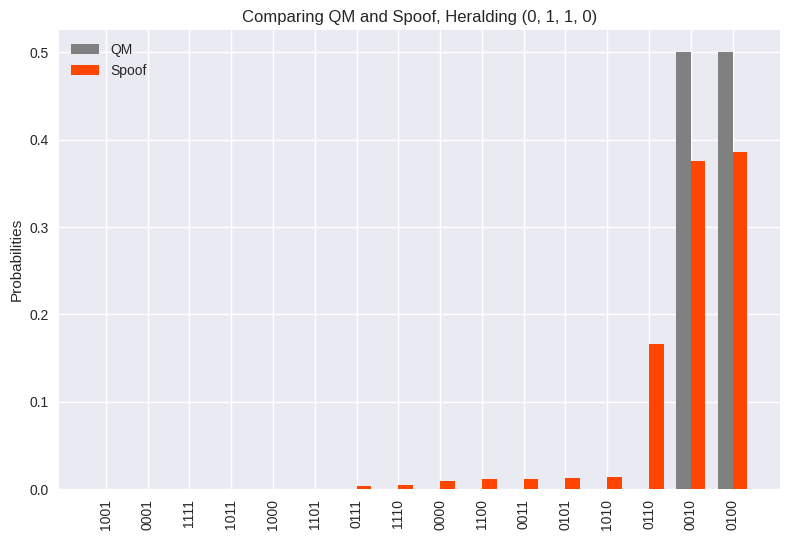

Trace Distance: 0.23791291291291267
Hellinger Distance: 0.35643055289172176
Chi-Square Test Statistic: 0.0001716665291348186
Chi-Square p-value: 0.9895462899719235



In [11]:
# Hong-Ou-Mandel Experiment
U = direct_sum(I1, hadamard, I1)
analyze_estu(2, U=U, heralds=[(0,1,1,0)], N=1000000)

### Haar-Random Unitary

In [12]:
x0 = [1, DEFAULT_MEAS_THRESH, DEFAULT_MEAS_THRESH]
res = minimize(optimizable_estu, x0, method='Nelder-Mead', tol=1e-2)
res.x

array([1.12044574, 1.77978084, 1.85967855])

In [13]:
print(optimizable_estu(res.x))

0.2901213565504722


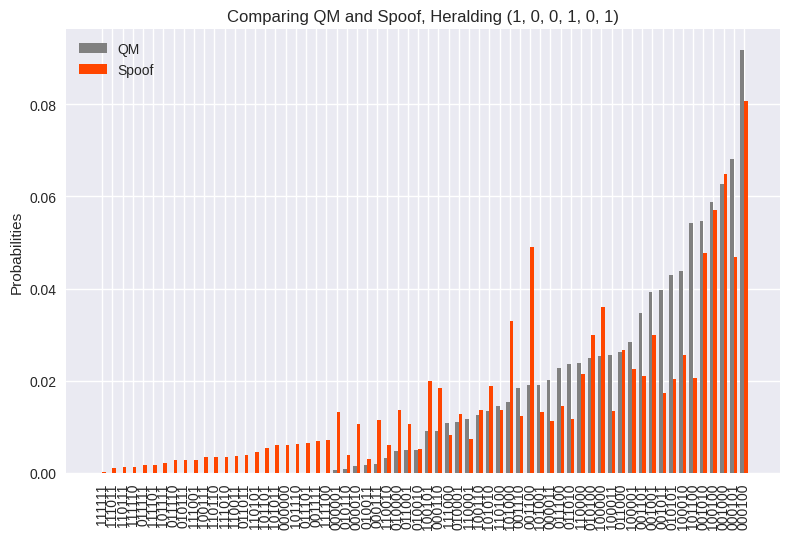

Trace Distance: 0.23006978757547464
Hellinger Distance: 0.27644100172079356
Chi-Square Test Statistic: 0.6473646618047715
Chi-Square p-value: 1.0



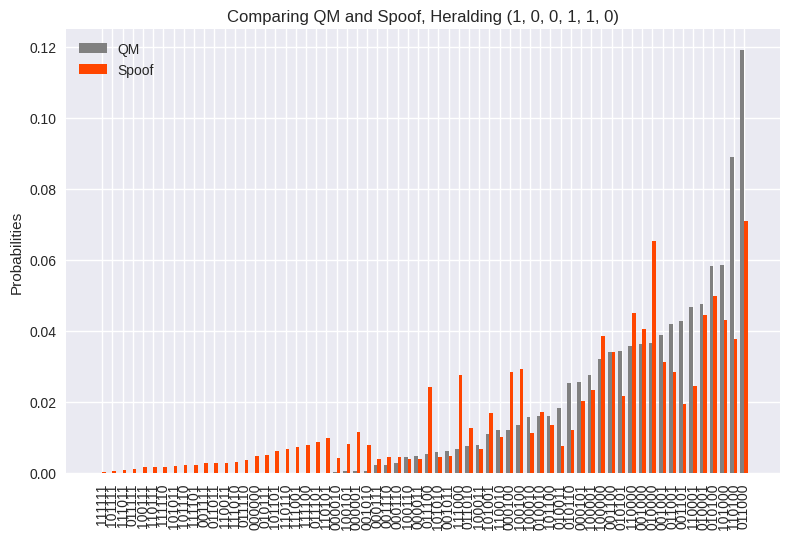

Trace Distance: 0.25291511839413156
Hellinger Distance: 0.2885502345328555
Chi-Square Test Statistic: 1.031982309538356
Chi-Square p-value: 1.0



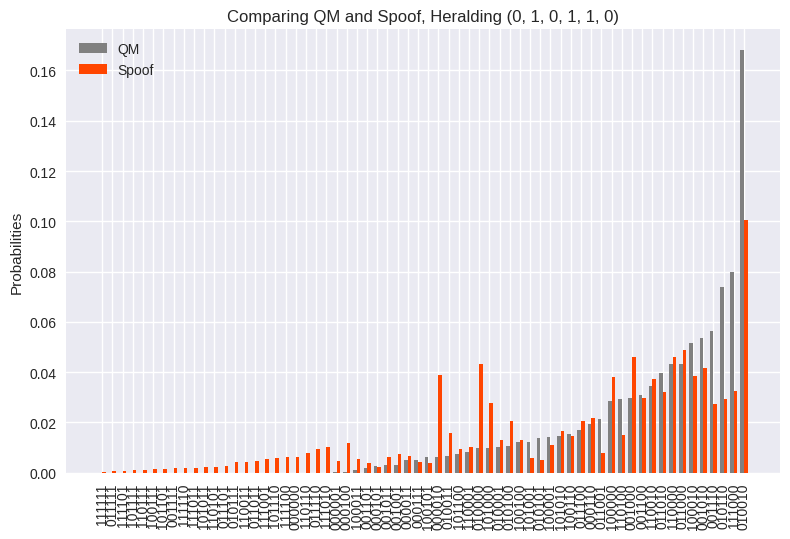

Trace Distance: 0.2722425245120237
Hellinger Distance: 0.3024410302616963
Chi-Square Test Statistic: 1.3030006502846263
Chi-Square p-value: 1.0



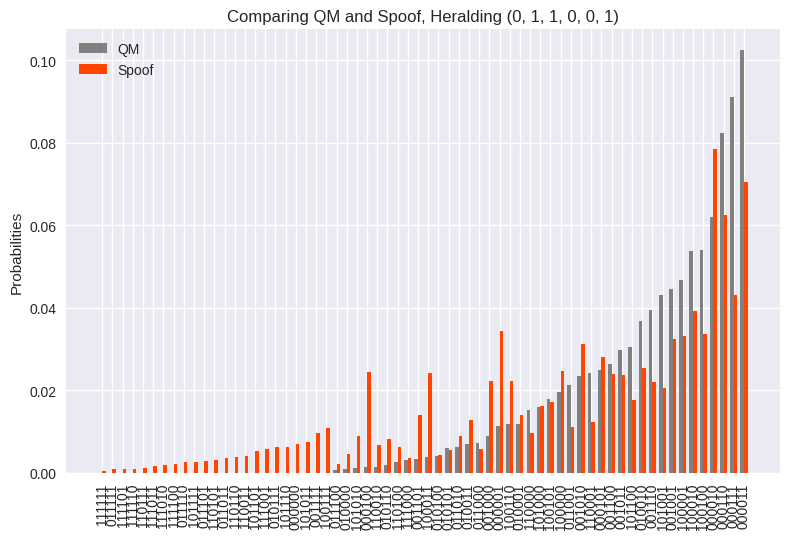

Trace Distance: 0.263084147536736
Hellinger Distance: 0.29563688990668535
Chi-Square Test Statistic: 1.0125227814929054
Chi-Square p-value: 1.0



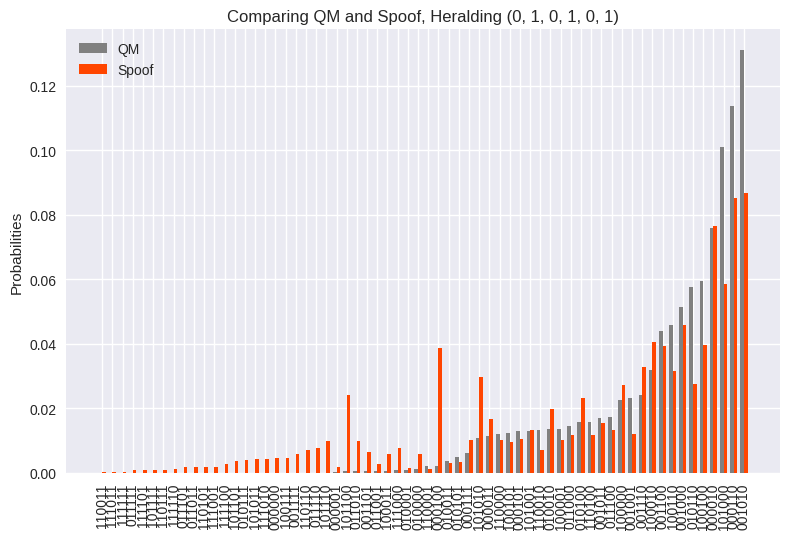

Trace Distance: 0.2334718376838049
Hellinger Distance: 0.288233241703372
Chi-Square Test Statistic: 2.9430921680527122
Chi-Square p-value: 0.9999999999999998



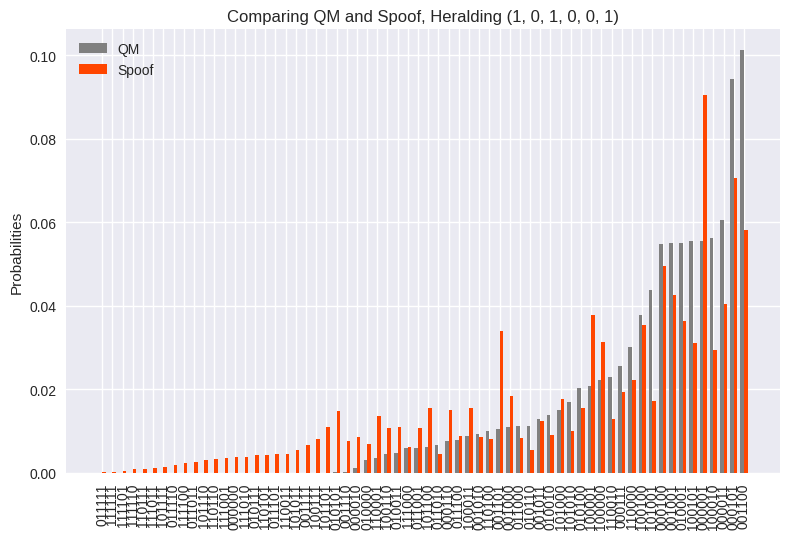

Trace Distance: 0.25785398736109155
Hellinger Distance: 0.2808334384749255
Chi-Square Test Statistic: 2.2568363926444643
Chi-Square p-value: 1.0



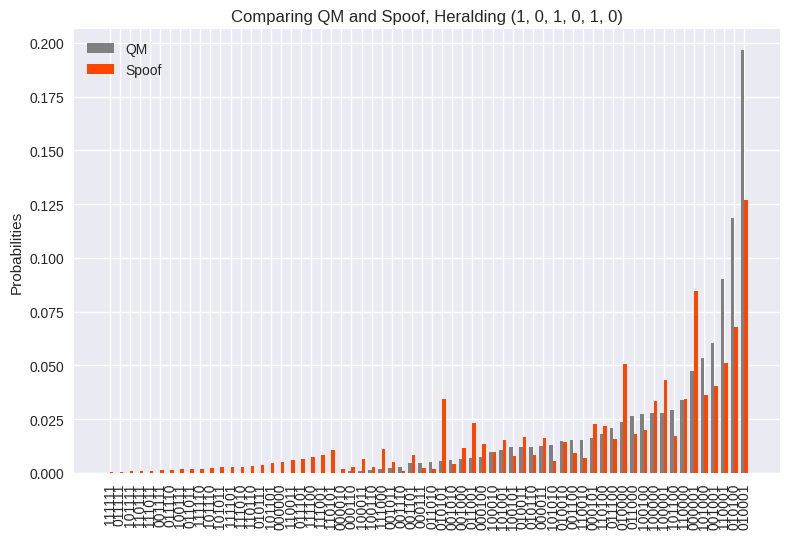

Trace Distance: 0.26856054874612967
Hellinger Distance: 0.27649862425398
Chi-Square Test Statistic: 0.6061102065344746
Chi-Square p-value: 1.0



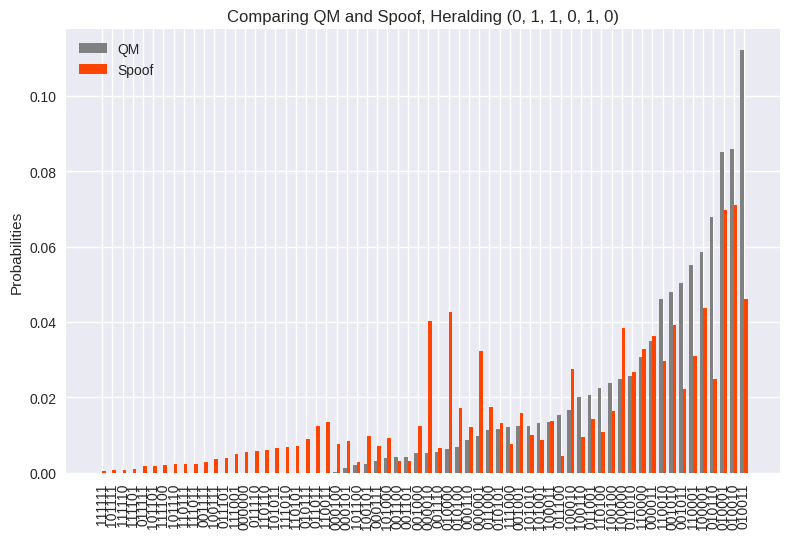

Trace Distance: 0.2924186408270466
Hellinger Distance: 0.32597376409595674
Chi-Square Test Statistic: 1.3004616932312376
Chi-Square p-value: 1.0

---
General statistics:
Average Trace Distance: 0.25882707407955485
Average Hellinger Distance: 0.2918260281187831
Average Chi-Square Test Statistic: 1.3876713579479434
Average Chi-Square p-value: 1.0


In [14]:
analyze_estu(
    3, 
    r=res.x[0], 
    herald_gamma=res.x[1], 
    out_gamma=res.x[2], 
    N=1000000
)

In [15]:
# past hellinger dist optimizations
print(optimizable_estu([1.08297325, 1.70032542, 1.82342849]))
print(optimizable_estu([1.1055373 , 1.82534494, 1.88541628]))

# past trace dist optimizations
print(optimizable_estu([1.01692816, 1.94235549, 1.9645503 ]))
print(optimizable_estu([1.08029835, 1.88512194, 1.88833083]))

0.29146256210348226
0.2836168987073152
0.33166838133828647
0.28242646268152755


### Basic Hadamard

In [16]:
# Optimizing Basic Hadamard
x0 = [1, DEFAULT_MEAS_THRESH, DEFAULT_MEAS_THRESH]
res = minimize(optimizable_estu, x0, 
               args=(1, hadamard, [(1,0)], 100000, 3), 
               method='Nelder-Mead', tol=1e-2)
res.x

array([1.02547429, 2.99813268, 2.45119104])

0.2649416912915179


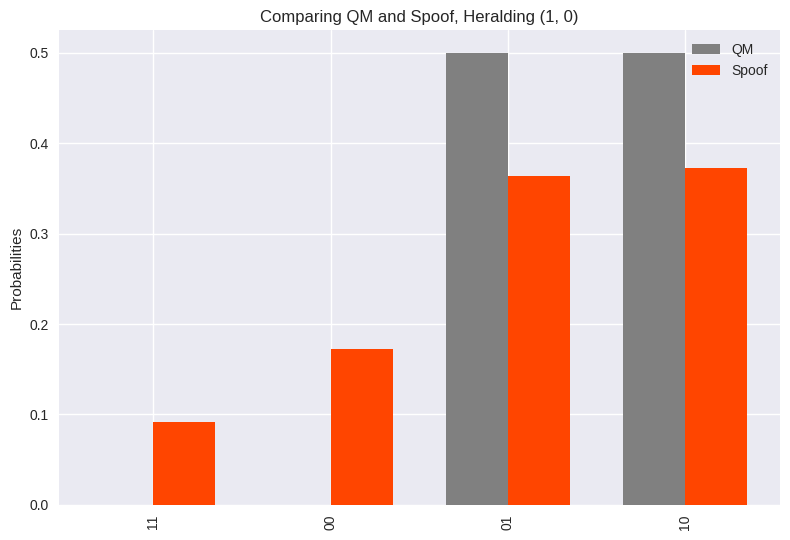

Trace Distance: 0.26358591657099106
Hellinger Distance: 0.3766562582854565
Chi-Square Test Statistic: 0.00014598993795284155
Chi-Square p-value: 0.9903596909567518



In [17]:
print(optimizable_estu(res.x, 1, hadamard, [(1,0)], 100000, 10))
analyze_estu(
    1,
    U=hadamard,
    heralds=[(1,0)],
    r=res.x[0], 
    herald_gamma=res.x[1], 
    out_gamma=res.x[2], 
    N=1000000
)

In [18]:
# past hellinger dist optimizations
print(optimizable_estu([1.03529492, 2.11390389, 1.81540191], 1, hadamard, [(1,0)], 100000, 10))

# past trace dist optimizations
print(optimizable_estu([1.01875   , 1.9494    , 2.01031875], 1, hadamard, [(1,0)], 100000, 10))
print(optimizable_estu([1.05   , 2.04687, 1.75446], 1, hadamard, [(1,0)], 100000, 10))

0.2946007231097104
0.42317595559963406
0.2984167924215929


### Hong-Ou Mandel

In [21]:
# Optimizing Hong-Ou-Mandel
U = direct_sum(I1, hadamard, I1)
x0 = [1, DEFAULT_MEAS_THRESH, DEFAULT_MEAS_THRESH]
res = minimize(optimizable_estu, x0, 
               args=(2, U, [(0,1,1,0)], 1000000, 3), 
               method='Nelder-Mead', tol=1e-2)
res.x

array([0.8468196 , 2.07243458, 2.16513259])

0.14778176525994186


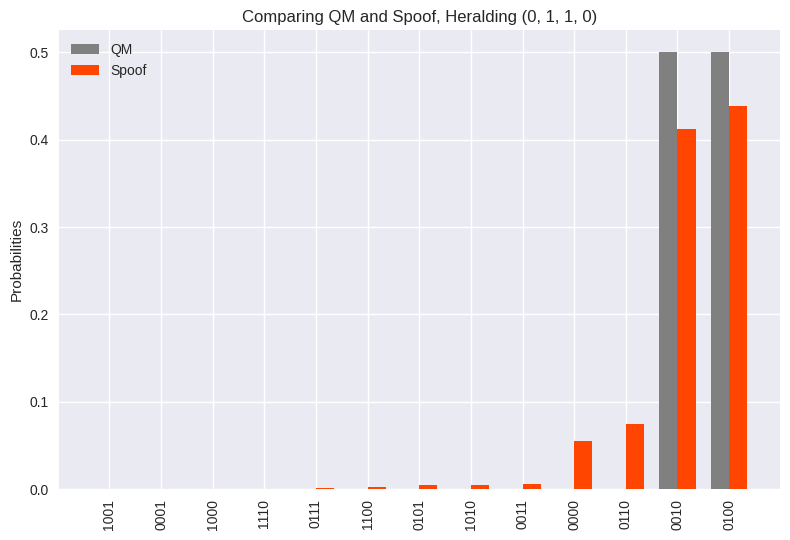

Trace Distance: 0.14974358974358956
Hellinger Distance: 0.27932045758223173
Chi-Square Test Statistic: 0.000983643292527656
Chi-Square p-value: 0.9749799781228442



In [22]:
print(optimizable_estu(res.x, 2, U, [(0,1,1,0)], 100000, 10))
analyze_estu(
    2,
    U=U,
    heralds=[(0,1,1,0)],
    r=res.x[0], 
    herald_gamma=res.x[1], 
    out_gamma=res.x[2], 
    N=1000000
)

In [23]:
# past hellinger dist optimizations
print(optimizable_estu([0.98920348, 1.85728697, 2.08022861], 2, U, [(0,1,1,0)], 1000000, 10)) # found with N=100000, shots=3
print(optimizable_estu([0.86703834, 2.05445921, 2.21177043], 2, U, [(0,1,1,0)], 1000000, 10)) # found with N=100000, shots=10

# past trace dist optimizations
print(optimizable_estu([1.05354938, 1.9160075 , 1.98339417], 2, U, [(0,1,1,0)], 1000000, 10))
print(optimizable_estu([0.78136336, 2.18881134, 2.31874163], 2, U, [(0,1,1,0)], 1000000, 10))

0.16573452595329138
0.15060470072406498
0.22674203748572816
0.14365739438978037
